In [21]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [37]:
trainset = torchvision.datasets.MNIST("./data/", train = True, transform=transforms.ToTensor(), download = False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validationset = torchvision.datasets.MNIST("./data/", train = False, transform=transforms.ToTensor(), download = False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=512, shuffle=True)

In [43]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))
net=NN()

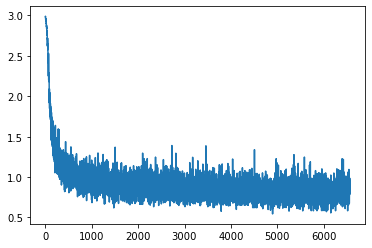

In [44]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss = torch.nn.CrossEntropyLoss()
losses=[]
lam=.001
e_opt=float('inf')
for epoch in range(100):
    print(epoch, '/', 100, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        l1_norm=sum(p.abs().sum() for p in net.parameters())
        losses.append(l)
        l+=lam*l1_norm
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    e_va=0
    net.eval()
    with torch.no_grad():
        for x, y in validationloader:
            out=net(x)
            e_va+=loss(out, y)
    if e_opt>e_va:
        e_opt=e_va
        torch.save(net.state_dict(), "./models/mnist.pt")
    e_opt=min(e_opt, e_va)
    gl=100*(e_va/e_opt-1)
    if gl>10:
        net.load_state_dict(torch.load("./models/mnist.pt"))
        break
from matplotlib import pyplot as plt
plt.plot(losses)

In [55]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in validationloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print(correct/len(validationset))

0.9326
